In [43]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 

db=mysql.connector.connect(
    host='localhost',
    user='root',
    password='S@gar7870',
    database='ecommerce'
)



In [ ]:
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items'),
]


# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='S@gar7870',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/sagar/Desktop/data analytics all project/python+sql/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [32]:
#Q.1) List all unique cities where customers are located.

cursor = db.cursor()

# Define the query to fetch unique cities
query = """SELECT DISTINCT customer_city FROM customers"""

cursor.execute(query)      # Execute the query
data = cursor.fetchall()   # Fetch the results
data                       #print the data


[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

In [45]:
#Q.2) Count the number of orders placed in 2017.

query = """
    SELECT COUNT(order_id) 
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2017;
"""

cursor.execute(query)     
data = cursor.fetchall()   
data                       



[(45101,)]

In [ ]:
#Q.3) Find the total sales per category.
query=""" SELECT products.product_category category , sum(payments.payment_value) sales
        FROM products JOIN order_items on products.product_id=order_items.product_id
        JOIN payments on payments.order_id=order_items.order_id 
        GROUP BY   category """ 
cursor.execute(query)     
data = cursor.fetchall()   
data   

[('perfumery', 506738.6598940939),
 ('Furniture Decoration', 1430176.3917766158),
 ('telephony', 486882.05071262456),
 ('Fashion Bags and Accessories', 218158.28002214432),
 ('bed table bath', 1712553.671003269),
 ('automotive', 852294.3311252594),
 ('computer accessories', 1585330.4462582897),
 ('housewares', 1094758.1302838866),
 ('babies', 539845.659735024),
 ('toys', 619037.6894793902),
 ('Furniture office', 646826.4871485233),
 ('Cool Stuff', 779698.0000486821),
 ('HEALTH BEAUTY', 1657373.1193935554),
 ('pet Shop', 311268.9703014195),
 ('General Interest Books', 64694.759615421295),
 ('stationary store', 317440.06965875626),
 ('Watches present', 1429216.6785924584),
 ('PCs', 279121.5493659973),
 ('climatization', 91170.65948677063),
 ('Construction Tools Construction', 241475.6302587986),
 ('sport leisure', 1392127.5591495223),
 ('Bags Accessories', 187151.29038503766),
 ('electronics', 259857.09967413358),
 ('Casa Construcao', 136645.29030653834),
 ('Games consoles', 195480.37912

In [58]:
#Q.4) Calculate the percentage of orders that were paid in installments.
query=""" SELECT 
    (COUNT(CASE WHEN payment_installments > 0 THEN 1 END) * 100.0 / COUNT(*)) 
    AS percentage_paid_in_installments FROM payments  """ 
cursor.execute(query)     
data = cursor.fetchall()   
data   


[(Decimal('99.99807'),)]

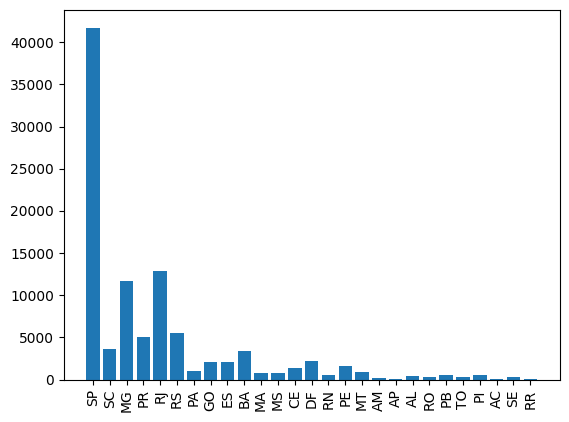

In [ ]:
# Q.5) Count the number of customers from each state. 
query=""" SELECT customer_state ,COUNT( customer_id) from customers 
        GROUP BY customer_state   """ 
cursor.execute(query)     
data = cursor.fetchall()   

df=pd.DataFrame(data,columns=["state","No._of_orders"])
# df

#plot bar 
plt.bar(df["state"],df["No._of_orders"])
plt.xticks(rotation=90)
plt.show()